In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("cubehelix", 8)#"deep")
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from problem_creator import gen_regression_symbolic, gen_classification_symbolic
from scipy.stats import weightedtau
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.evaluate import feature_importance_permutation

## Utils

In [54]:
def create_test_data_uniform(data_points=1000, num_features=5, coeffs=None, data_params=None):
    if not data_params:
        data_params=(-1,1)
    if not coeffs:
        coeffs = [(i+1)*2 for i in range(num_features)]
    x = []
    for i in range(len(coeffs)):
        x.append(np.random.uniform(data_params[0],data_params[1],data_points))
    x = np.array(x).T
    fi = deepcopy(x)
   # print(coeffs)
    for i in range(len(coeffs)):
        fi[:,i] = fi[:,i]*coeffs[i]
    y = fi.sum(1)
    return x, y, fi

def create_test_data_normal(data_points=1000, num_features=5, coeffs=[], data_params=None):
    if not data_params:
        data_params=(0,1)
    if len(coeffs) == 0:
        coeffs = [(i+1)*2 for i in range(num_features)]
    x = []
    for i in range(len(coeffs)):
        x.append(np.random.normal(data_params[0],data_params[1],data_points))
    x = np.array(x).T
    fi = deepcopy(x)
    for i in range(len(coeffs)):
        fi[:,i] = fi[:,i]*coeffs[i]
    y = fi.sum(1)
    return x, y, fi

In [ ]:
# x, y, fi = create_test_data_uniform()
# split = round(x.shape[0]*0.8)
# x_train = x[:split,:] #train_test_split(x, y, test_size=0.2)#, random_state=7)
# y_train = y[:split]
# x_test = x[split:,:]
# y_test = y[split:]
# feature_names = [i for i in range(x.shape[1])]
# x_train_df = pd.DataFrame(x_train,columns=feature_names)
# x_test_df = pd.DataFrame(x_test,columns=feature_names)
# dtrain = xgb.DMatrix(data=x_train_df, label=y_train)
# dtest = xgb.DMatrix(data=x_test_df, label=y_test)

## Read in Data with Interaction

In [56]:
data = pd.read_csv('data/Interactions_Continuous.csv')
data.head()

,Strength,Temperature,Pressure,Time
0,100.666667,100.59,81.10,33.32
1,97.777778,109.50,72.38,32.92
2,88.444444,103.98,74.62,35.32
3,85.444444,99.39,65.04,35.00
4,93.185185,107.25,67.42,32.80


In [85]:
# data['f0'] = data['Food'].astype('category').cat.codes
# data['f1'] = data['Condiment'].astype('category').cat.codes

X = data[['Temperature','Pressure','Time']]
X.columns = ['f0','f1','f2']
y = data[['Strength']]

dtrain = xgb.DMatrix(data=X, label=y)
dtrain.feature_names

['f0', 'f1', 'f2']

## PDP

[16:49:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


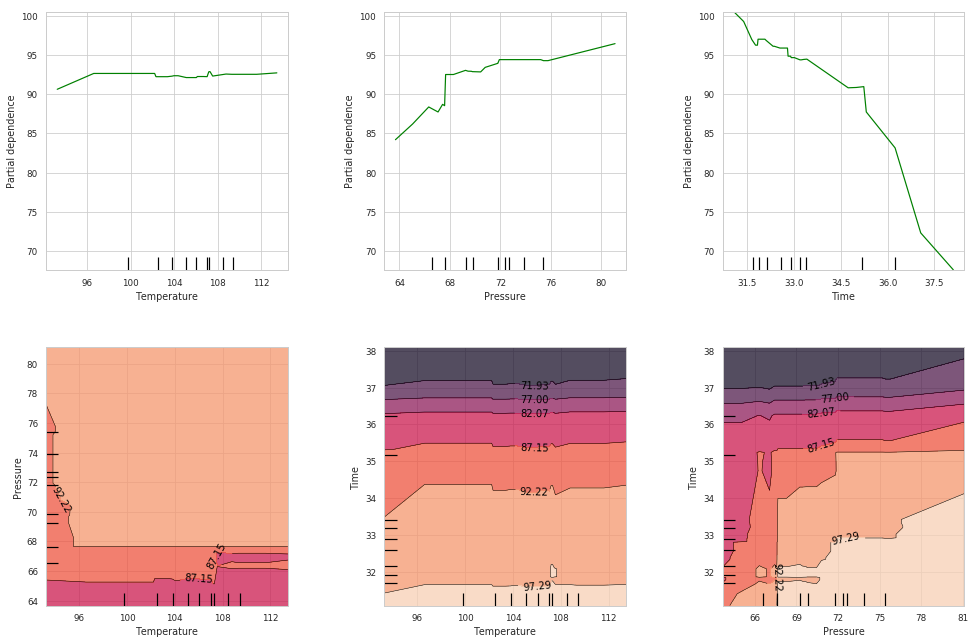

In [103]:
param = {'max_depth':2, 'eta':1, 'silent':1}
model = xgb.XGBRegressor(gbtree='gbtree').fit(X,y)
feature_names = ['Temperature','Pressure','Time']
#feature_names = ['f0','f1','f2']
#features = [0, 1, 2,(0, 1),(0, 2),(1,2)]
fig = plt.figure(figsize=(15,15))
plot_partial_dependence(model, X, features,feature_names=feature_names,fig=fig) 
plt.show()

## SHAP

In [73]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_coeffs = np.absolute(shap_values).mean(axis=0)

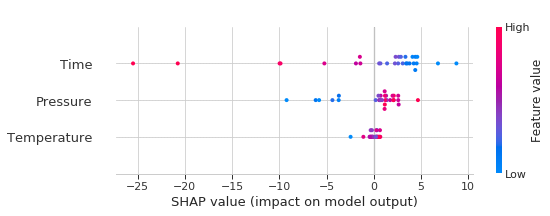

In [75]:
shap.summary_plot(shap_values, X)

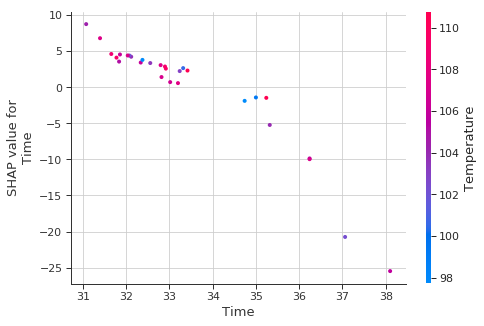

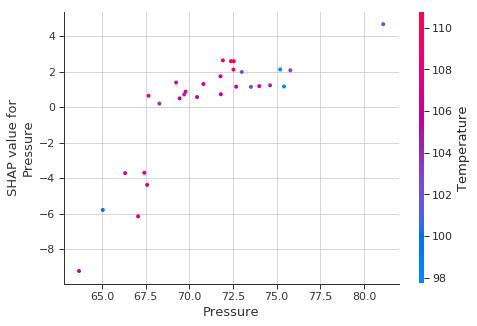

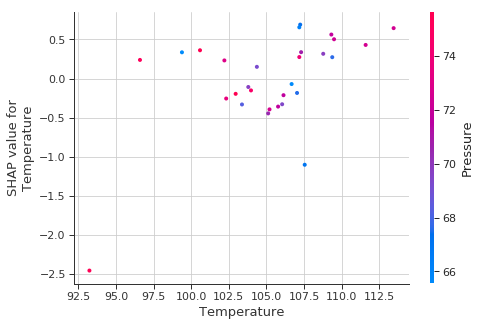

In [78]:
shap.dependence_plot('Time',shap_values,X)
plt.show()
shap.dependence_plot('Pressure',shap_values,X)
shap.dependence_plot('Temperature',shap_values,X)

# Create own Data

In [5]:
def simple_test_data_1(datapoints=1000, interaction_coeff=0.5):
    x1 = np.random.normal(0,1,datapoints)
    x2 = np.random.normal(0,1,datapoints)
    x3 = interaction_coeff*x1*x2
    y = 0.5*x1-x2+x3
    X = np.array([x1,x2]).T
    return X,y

## Apply PDP

[17:19:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


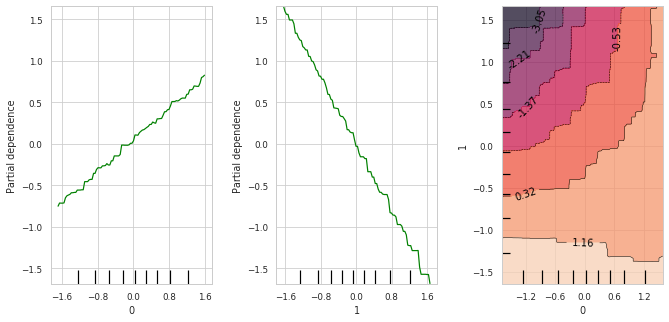

In [7]:
X,y = simple_test_data_1()
model = xgb.XGBRegressor(gbtree='gbtree').fit(X,y)
features = [0, 1,(0, 1)]
fig = plt.figure(figsize=(10,7))
plot_partial_dependence(model, X, features,fig=fig) 
plt.show()

## Apply SHAP

In [128]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap_coeffs = np.absolute(shap_values).mean(axis=0)

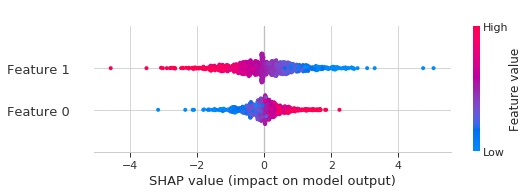

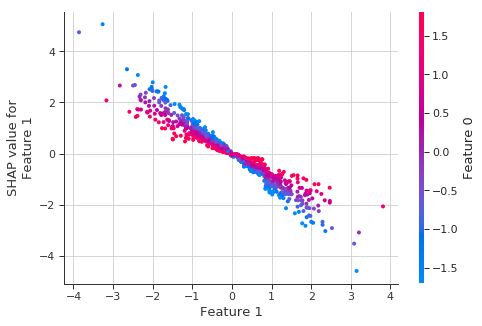

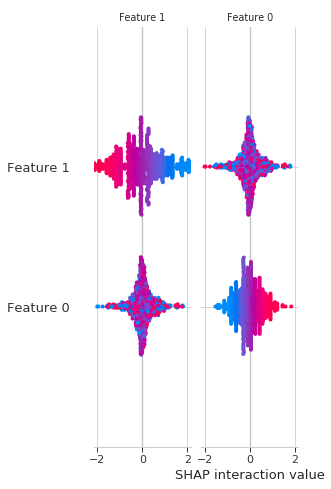

In [131]:
shap.summary_plot(shap_values, X)
shap.dependence_plot('Feature 1',shap_values,X)
# shap.dependence_plot('Feature 0',shap_values,X)
# shap.dependence_plot('Temperature',shap_values,X)
shap_interaction_values = explainer.shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X, plot_type='dot')

### Show FI values

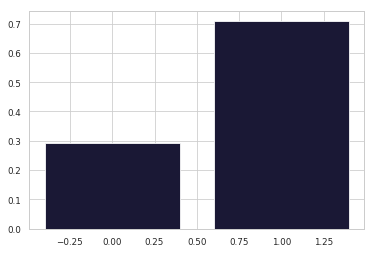

<BarContainer object of 2 artists>

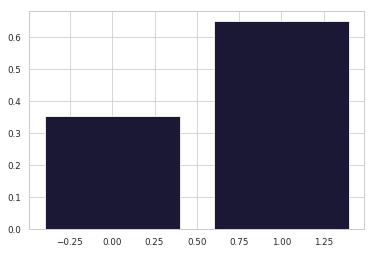

In [150]:
m_fi, a_fi = feature_importance_permutation(X,y,model.predict,metric='r2',num_rounds=10)
plt.bar(range(len(m_fi)),m_fi/m_fi.sum())
plt.show()
#shap_coeffs
plt.bar(range(len(shap_coeffs)),shap_coeffs/shap_coeffs.sum())

## Create different data

In [229]:
datapoints = 1000
#x1 = np.random.normal(0,1,datapoints)
#x2 = np.random.normal(0,1,datapoints)
x1 = np.random.uniform(-1,1,datapoints)
x2 = np.random.uniform(-1,1,datapoints)
x3 = np.zeros(datapoints)
x4 = np.random.uniform(-1,1,datapoints)
x5 = np.random.uniform(-1,1,datapoints)
x3[x1 > 0] = x1[x1 > 0]*x2[x1 > 0]
x3[x1 <= 0] = x1[x1 <= 0]*-x2[x1 <= 0]
#x3 = x1*x2
y = 1*x1+2*x2+x3#+4*x4+x5
x = np.array([x1,x2]).T


## Train model and apply SHAP

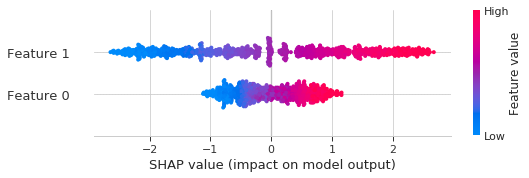

In [230]:
model = xgb.XGBRegressor(gbtree='gbtree', objective='reg:squarederror').fit(x,y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_coeffs = np.absolute(shap_values).mean(axis=0)
shap.summary_plot(shap_values, x, plot_type='dot')

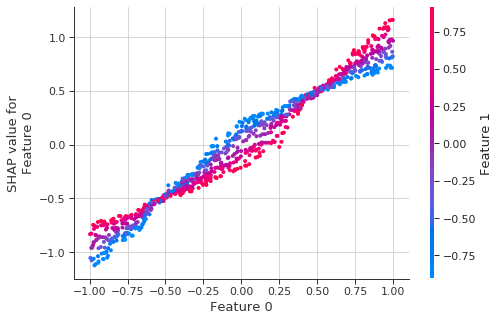

In [231]:
shap.dependence_plot('Feature 0',shap_values,x)

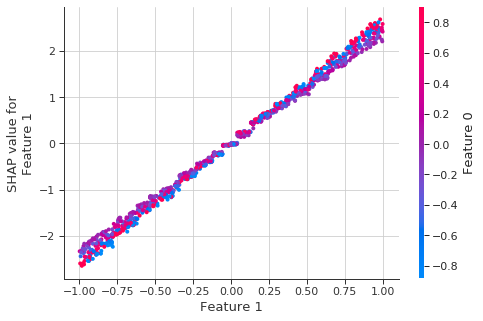

In [232]:
shap.dependence_plot('Feature 1',shap_values,x,interaction_index=0)

## Apply PDP

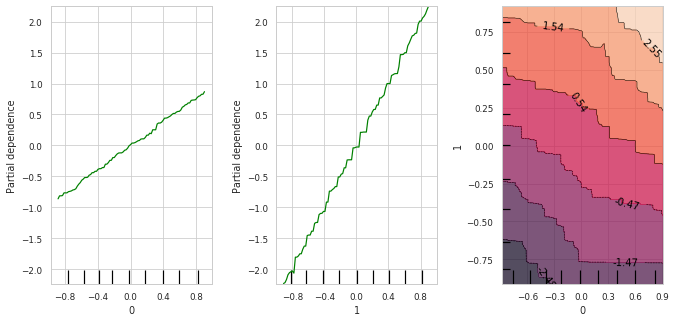

In [233]:
features = [0, 1,(0, 1)]
fig = plt.figure(figsize=(10,7))
plot_partial_dependence(model, x, features,fig=fig) 
plt.show()

### More experiments

In [234]:
datapoints = 1000
x0 = np.random.uniform(-1,1,datapoints)
x1 = np.random.uniform(-1,1,datapoints)
x2 = np.random.uniform(-1,1,datapoints)
x3 = np.random.uniform(-1,1,datapoints)

x01 = x0*x1
x02 = x0*x2
x12 = x1*x2

y = x0 + x1 + x2 + x3 + x01 + x02 + x12
x = np.array([x0,x1,x2,x3]).T

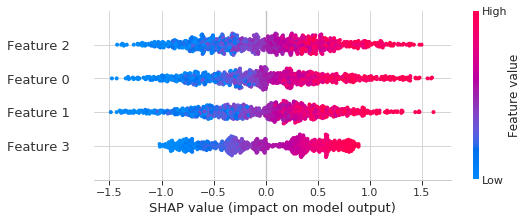

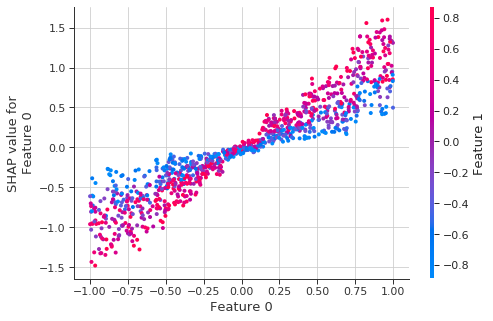

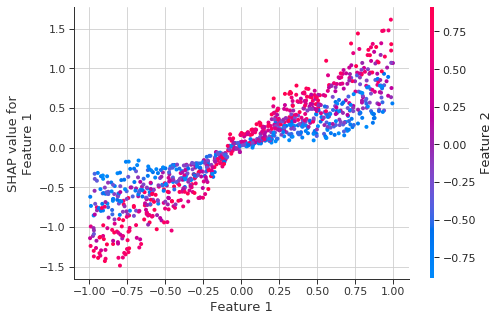

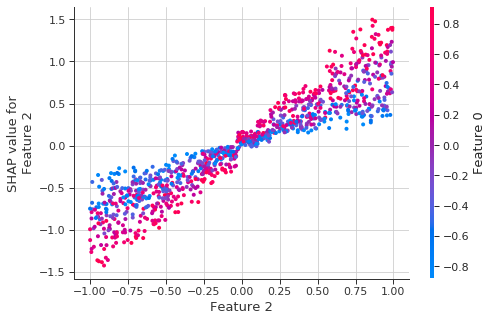

In [235]:
model = xgb.XGBRegressor(gbtree='gbtree', objective='reg:squarederror').fit(x,y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_coeffs = np.absolute(shap_values).mean(axis=0)
shap.summary_plot(shap_values, x, plot_type='dot')
shap.dependence_plot('Feature 0',shap_values,x,interaction_index=1)
shap.dependence_plot('Feature 1',shap_values,x,interaction_index=2)
shap.dependence_plot('Feature 2',shap_values,x,interaction_index=0)

In [236]:
datapoints = 1000
x0 = np.random.uniform(-1,1,datapoints)
x1 = np.random.uniform(-1,1,datapoints)
x2 = np.random.uniform(-1,1,datapoints)
x3 = np.random.uniform(-1,1,datapoints)

x01 = x0*x1
x02 = x0*x2
x12 = x1*x2

y = x0 + x1 + x2 + x3 + x01 + x02 + x12
x = np.array([x0,x1,x2]).T
print(x.mean(axis=0).round(2))

[-0.03  0.01 -0.01]


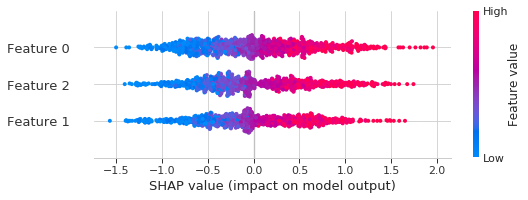

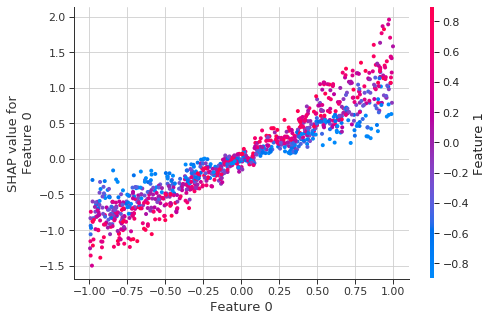

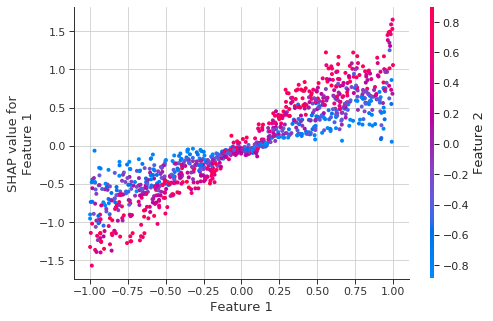

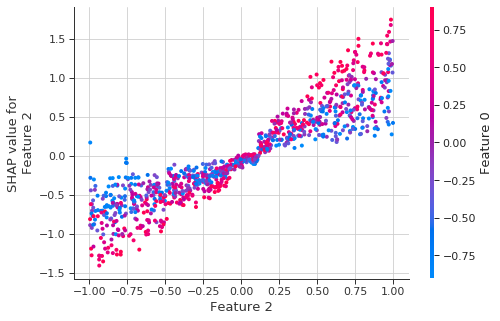

In [237]:
model = xgb.XGBRegressor(gbtree='gbtree', objective='reg:squarederror').fit(x,y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_coeffs = np.absolute(shap_values).mean(axis=0)
shap.summary_plot(shap_values, x, plot_type='dot')
shap.dependence_plot('Feature 0',shap_values,x,interaction_index=1)
shap.dependence_plot('Feature 1',shap_values,x,interaction_index=2)
shap.dependence_plot('Feature 2',shap_values,x,interaction_index=0)